In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import tensorflow as tf
from datetime import datetime
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW
from modules.training.ts_modeling import (
    build_dataset,
    create_gru,
    create_gru_with_addition_skips,
    create_gru_with_concatenation_skips,
    evaluate_model,
    evaluate_model_cond,
    process_sep_events,
    get_loss,
    reshape_X)

C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wan

In [30]:
def synth_line45(num_samples: int, shuffle: bool = False, debug: bool = False, change: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates synthetic training data for an RNN model. The dataset consists
    of pairs (X, y) where X represents 25 successive data points on a normalized
    45-degree line, and y represents the normalized value on the line 45 degrees
    at 30 minutes into the future of the last point in X. If 'change' is True,
    y represents the change between the last point in X and the future value.

    Parameters
    ----------
    num_samples : int
        The number of (X, y) pairs to generate.
    shuffle : bool, optional
        If True, the resulting dataset will be shuffled. Defaults to False.
    debug : bool, optional
        If True, plots the first 5 generated data points along with their future
        values to visually confirm the 45-degree line. Defaults to False.
    change : bool, optional
        If True, the target value y will be the change from the last X value to
        the target y. Defaults to False.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing two numpy arrays: X and y.
        X is a 2D array with the shape (num_samples, 25), representing the input
        features.
        y is a 1D array with the length of num_samples, representing the target
        values or the change in target values 30 minutes into the future of the last
        point in each corresponding X.
    """
    # Generate dataset
    start_times = np.linspace(0, 1, num_samples, endpoint=False)  # Normalize to the range [0, 1]
    X = np.array([start_time + np.linspace(0, 1, 25, endpoint=False) for start_time in start_times])
    original_y = start_times + 1 / 24 * 31  # Normalize y to the range [0, 1]

    # Calculate the change if required
    y = original_y - X[:, -1] if change else original_y

    if shuffle:
        # Shuffle the dataset
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
    
    if debug:
        # Plot the first 5 X sequences and their corresponding y values
        plt.figure(figsize=(10, 6))
        for i in range(min(5, num_samples)):
            plt.plot(np.arange(25), X[i], marker='o', label=f'X[{i}]')
            plt.plot(25, y[i], marker='x', markersize=10, label=f'y[{i}]', linestyle="None")
        plt.title('First 5 Samples on a Normalized 45-degree Line')
        plt.xlabel('Time (arbitrary units)')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    
    return X, y

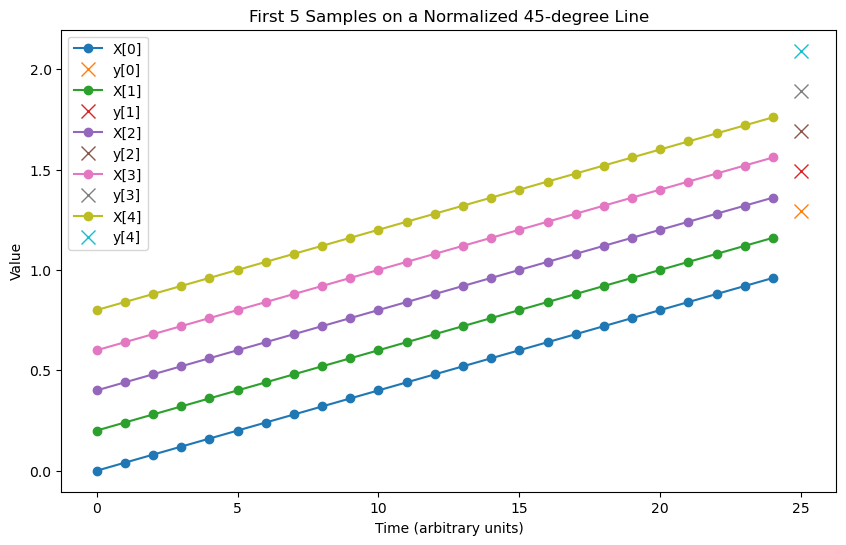

(array([[0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
         0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
         0.88, 0.92, 0.96],
        [0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 ,
         0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04,
         1.08, 1.12, 1.16],
        [0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 ,
         0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24,
         1.28, 1.32, 1.36],
        [0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  ,
         1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 , 1.44,
         1.48, 1.52, 1.56],
        [0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ,
         1.24, 1.28, 1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64,
         1.68, 1.72, 1.76]]),
 array([1.29166667, 1.49166667, 1.69166667, 1.89166667, 2.09166667]))

In [31]:
synth_line45(5, debug=True)


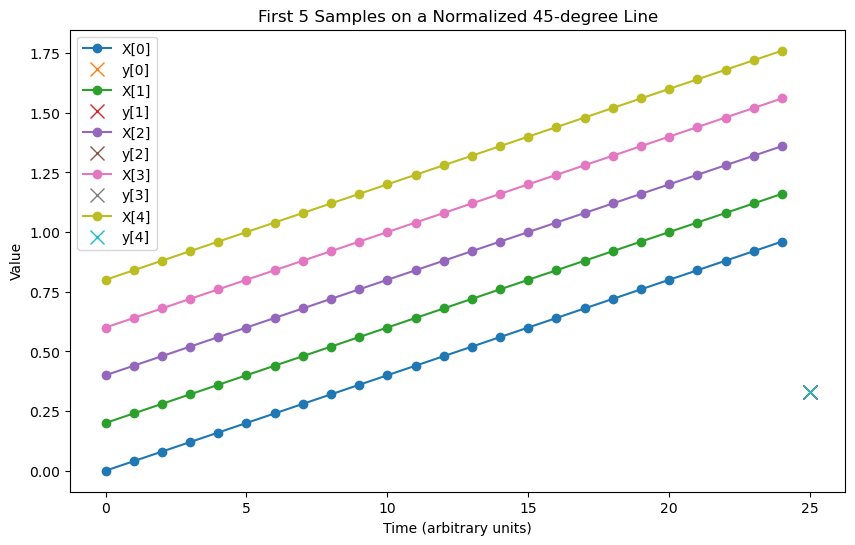

(array([[0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
         0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
         0.88, 0.92, 0.96],
        [0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 ,
         0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04,
         1.08, 1.12, 1.16],
        [0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 ,
         0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24,
         1.28, 1.32, 1.36],
        [0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84, 0.88, 0.92, 0.96, 1.  ,
         1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 , 1.44,
         1.48, 1.52, 1.56],
        [0.8 , 0.84, 0.88, 0.92, 0.96, 1.  , 1.04, 1.08, 1.12, 1.16, 1.2 ,
         1.24, 1.28, 1.32, 1.36, 1.4 , 1.44, 1.48, 1.52, 1.56, 1.6 , 1.64,
         1.68, 1.72, 1.76]]),
 array([0.33166667, 0.33166667, 0.33166667, 0.33166667, 0.33166667]))

In [32]:
synth_line45(5, debug=True, change=True)

In [79]:
def _generate_sawtooth(length: int, peak: int) -> np.ndarray:
    """
    Generates a sawtooth pattern with alternating 45-degree slopes up and down.

    Parameters
    ----------
    length : int
        The total length of the pattern to generate.
    peak : int
        The peak value before the pattern turns downward.

    Returns
    -------
    np.ndarray
        The sawtooth pattern as a 1D numpy array with values between 0 and 1.
    """
    pattern = np.arange(length) % (2 * peak)  # Period is twice the peak for up and down
    pattern = np.where(pattern < peak, pattern, 2 * peak - pattern) / peak
    return pattern

def synth_triangles(
        num_samples: int, 
        shuffle: bool = False, 
        debug: bool = False, 
        change: bool = False,
        seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates synthetic training data based on a triangular wave pattern.
    Each sample consists of 25 consecutive points on the curve, with the target
    value (y) being the point 6 steps (30 minutes) into the future.
    If 'change' is True, y represents the change between the last point in X and the future value.
    
    Parameters
    ----------
    num_samples : int
        The number of samples to generate.
    shuffle : bool, optional
        Whether to shuffle the samples.
    debug : bool, optional
        Whether to plot the first few samples for debugging.
    change : bool, optional
        If True, the target value y will be the change from the last X value to
        the target y. Defaults to False.
    seed : int, optional

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The generated X and y samples as numpy arrays.
    """
     # Set the random seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)
    
    peak = 5  # The peak of the sawtooth wave; 45 degrees up for 5 steps and down for 5 steps
    pattern_length = num_samples + 31  # To ensure we can sample all required X and corresponding y
    sawtooth_pattern = _generate_sawtooth(pattern_length, peak)

    # Sample starting indices
    # start_indices = np.random.randint(0, pattern_length - 31, num_samples)
    start_indices = np.random.choice(range(pattern_length - 31), num_samples, replace=False)

    # Generate samples
    X = np.array([sawtooth_pattern[start:start + 25] for start in start_indices])
    original_y = np.array([sawtooth_pattern[start + 31] for start in start_indices])

    # Calculate the change if required
    y = original_y - X[:, -1] if change else original_y

    if shuffle:
        indices = np.random.permutation(num_samples)
        X, y = X[indices], y[indices]

    if debug:
        plt.figure(figsize=(12, 8))
        time_points = np.arange(25 + 6)
        for i in range(min(5, num_samples)):
            plt.plot(time_points[:-6], X[i], marker='o', label=f'X[{i}]')
            plt.plot(time_points[-1], y[i] if not change else X[i, -1] + y[i], marker='x', markersize=10, label=f'y[{i}]', linestyle="None")
        plt.title('First 5 Samples on the Curve with Change' if change else 'First 5 Samples on the Curve')
        plt.xlabel('Time (arbitrary units)')
        plt.ylabel('Change in Value' if change else 'Value')
        plt.legend()
        plt.show()

    return X, y

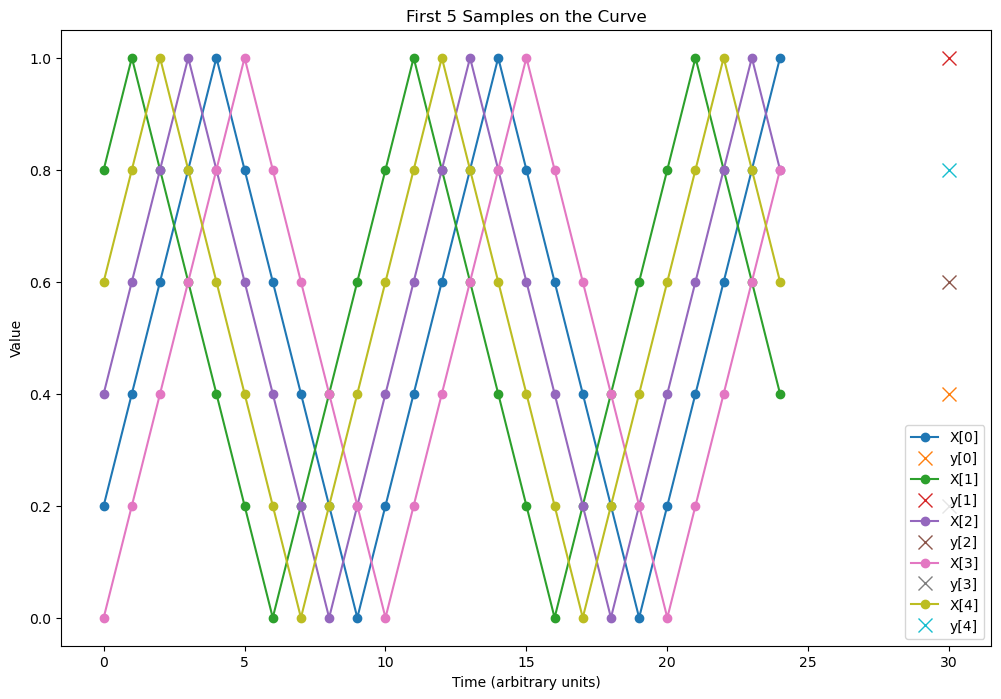

(array([[0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6,
         0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8, 1. ],
        [0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8,
         0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4],
        [0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8,
         1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8],
        [0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4,
         0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8],
        [0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8, 1. ,
         0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6]]),
 array([0.4, 1. , 0.6, 0.2, 0.8]))

In [80]:
synth_triangles(5, debug=True)


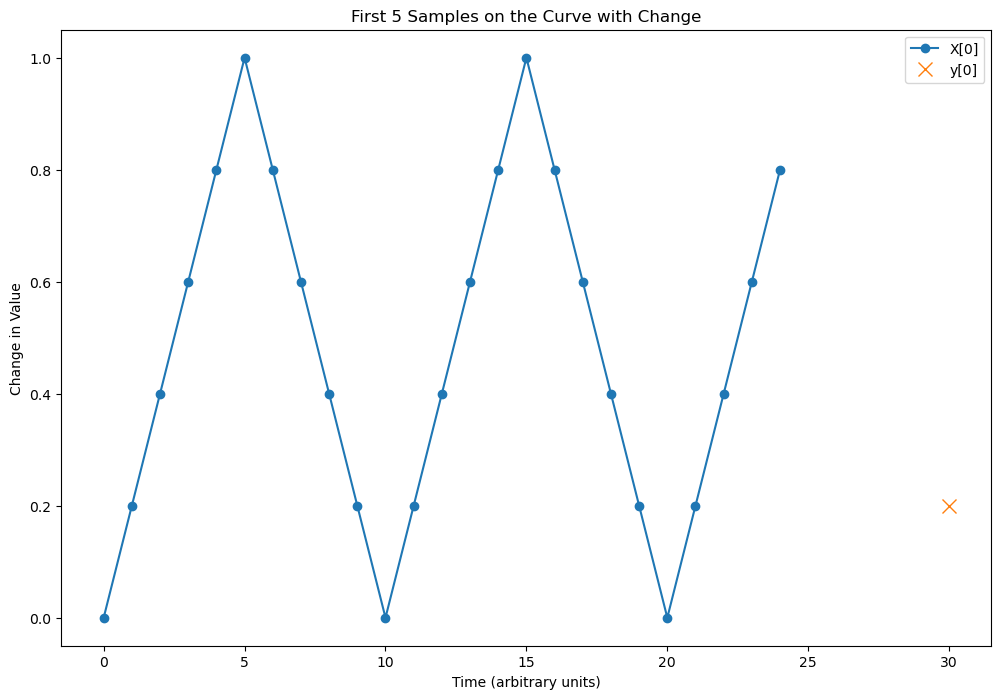

(array([[0. , 0.2, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4,
         0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2, 0.4, 0.6, 0.8]]),
 array([-0.6]))

In [42]:
synth_triangles(1, debug=True, change=True)

In [2]:
def synth_sine(num_samples: int, shuffle: bool = False, debug: bool = False, change: bool = False, seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates synthetic training data for an RNN model based on a sine curve. The dataset consists
    of pairs (X, y) where X represents 25 successive data points on a sine wave, and y represents
    the value on the sine wave at 30 minutes into the future of the last point in X. If 'change' is True,
    y represents the change between the last point in X and the future value.

    Parameters
    ----------
    num_samples : int
        The number of (X, y) pairs to generate.
    shuffle : bool, optional
        If True, the resulting dataset will be shuffled. Defaults to False.
    debug : bool, optional
        If True, plots the first 5 generated data points along with their future
        values to visually confirm the sine curve. Defaults to False.
    change : bool, optional
        If True, the target value y will be the change from the last X value to
        the target y. Defaults to False.
    seed : int, optional
        The seed for the random number generator. Defaults to None.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing two numpy arrays: X and y.
        X is a 2D array with the shape (num_samples, 25), representing the input
        features.
        y is a 1D array with the length of num_samples, representing the target
        values or the change in target values 30 minutes into the future of the last
        point in each corresponding X.
    """
    # Set the random seed for reproducibility if provided
    if seed is not None:
        np.random.seed(seed)

    # Time step between points, assuming each step represents 5 minutes.
    time_step = 5.0 / 60.0  # 5 minutes in hours if we assume time is in hours
    # Total period of the sine wave in hours, let's assume we want 2 full cycles in 24 hours
    period = 12.0
    
    # Generate equally spaced time values
    time_values = np.linspace(0, 24, num_samples + 31, endpoint=False)
    # Generate the sine wave values
    sine_values = np.sin(2 * np.pi * time_values / period)

    # Generate X and y samples
    X = np.array([sine_values[start:start + 25] for start in range(num_samples)])
    original_y = sine_values[25:25 + num_samples]  # Corresponding y values 30 minutes into the future

    # Calculate the change if required
    y = original_y - X[:, -1] if change else original_y

    if shuffle:
        # Shuffle the dataset
        indices = np.random.permutation(num_samples)
        X, y = X[indices], y[indices]
    
    if debug:
        # Plot the first 5 X sequences and their corresponding y values
        plt.figure(figsize=(10, 6))
        for i in range(min(5, num_samples)):
            plt.plot(time_values[:25], X[i], marker='o', label=f'X[{i}]')
            plt.plot(time_values[25], y[i] if not change else X[i, -1] + y[i], marker='x', markersize=10, label=f'y[{i}]', linestyle="None")
        plt.title('First 5 Samples on the Sine Curve' + (' with Change' if change else ''))
        plt.xlabel('Time (hours)')
        plt.ylabel('Sine Value' + (' Change' if change else ''))
        plt.legend()
        plt.show()
    
    return X, y

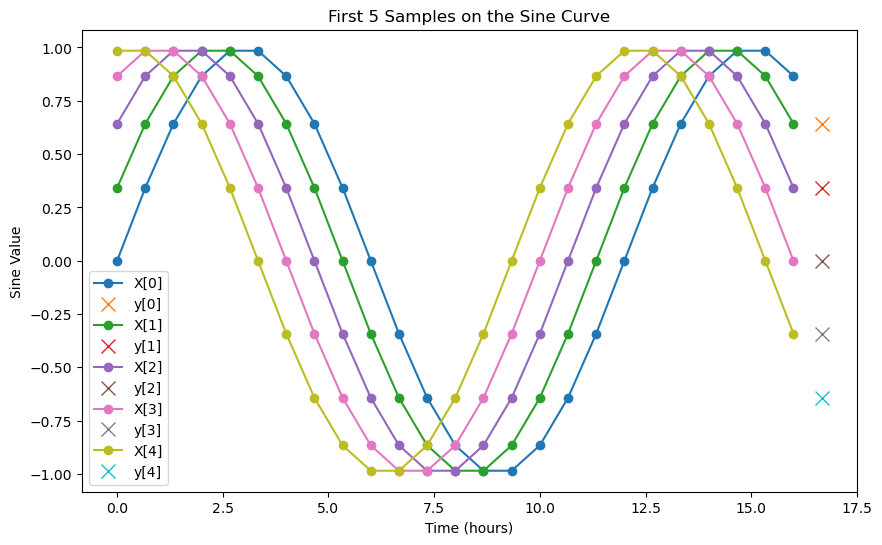

(array([[ 0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
          8.66025404e-01,  9.84807753e-01,  9.84807753e-01,
          8.66025404e-01,  6.42787610e-01,  3.42020143e-01,
          1.22464680e-16, -3.42020143e-01, -6.42787610e-01,
         -8.66025404e-01, -9.84807753e-01, -9.84807753e-01,
         -8.66025404e-01, -6.42787610e-01, -3.42020143e-01,
         -2.44929360e-16,  3.42020143e-01,  6.42787610e-01,
          8.66025404e-01,  9.84807753e-01,  9.84807753e-01,
          8.66025404e-01],
        [ 3.42020143e-01,  6.42787610e-01,  8.66025404e-01,
          9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
          6.42787610e-01,  3.42020143e-01,  1.22464680e-16,
         -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
         -9.84807753e-01, -9.84807753e-01, -8.66025404e-01,
         -6.42787610e-01, -3.42020143e-01, -2.44929360e-16,
          3.42020143e-01,  6.42787610e-01,  8.66025404e-01,
          9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
          6.4

In [47]:
synth_sine(5, debug=True)

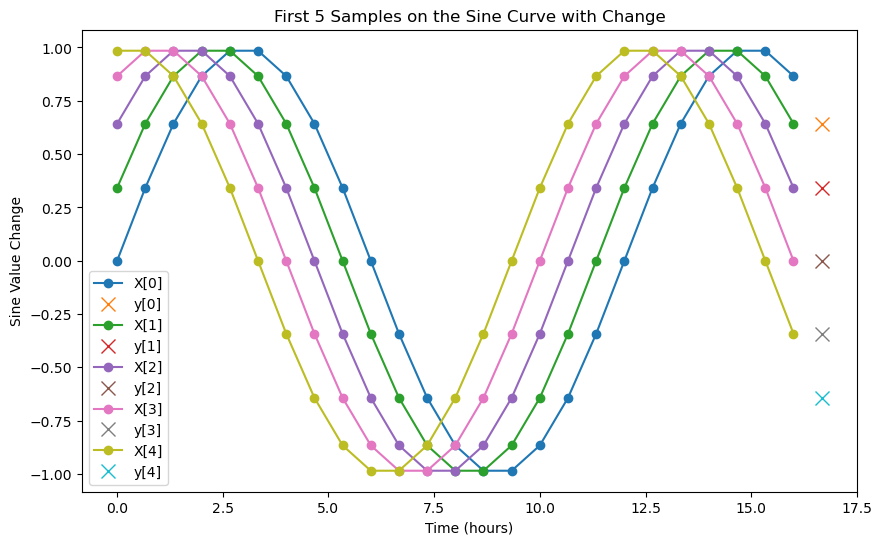

(array([[ 0.00000000e+00,  3.42020143e-01,  6.42787610e-01,
          8.66025404e-01,  9.84807753e-01,  9.84807753e-01,
          8.66025404e-01,  6.42787610e-01,  3.42020143e-01,
          1.22464680e-16, -3.42020143e-01, -6.42787610e-01,
         -8.66025404e-01, -9.84807753e-01, -9.84807753e-01,
         -8.66025404e-01, -6.42787610e-01, -3.42020143e-01,
         -2.44929360e-16,  3.42020143e-01,  6.42787610e-01,
          8.66025404e-01,  9.84807753e-01,  9.84807753e-01,
          8.66025404e-01],
        [ 3.42020143e-01,  6.42787610e-01,  8.66025404e-01,
          9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
          6.42787610e-01,  3.42020143e-01,  1.22464680e-16,
         -3.42020143e-01, -6.42787610e-01, -8.66025404e-01,
         -9.84807753e-01, -9.84807753e-01, -8.66025404e-01,
         -6.42787610e-01, -3.42020143e-01, -2.44929360e-16,
          3.42020143e-01,  6.42787610e-01,  8.66025404e-01,
          9.84807753e-01,  9.84807753e-01,  8.66025404e-01,
          6.4

In [115]:
synth_sine(5, debug=True, change=True)

In [3]:
title = 'Debugging_GRU'
# Create a unique experiment name with a timestamp
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment_name = f'{title}_{current_time}'

# Set the early stopping patience and learning rate as variables
seed = 456789
tf.random.set_seed(seed)
np.random.seed(seed)
patience = 500  # higher patience
learning_rate = 5e-3  # og learning rate

reduce_lr_on_plateau = ReduceLROnPlateau(
                    monitor='loss',
                    factor=0.5,
                    patience=50,
                    verbose=1,
                    min_delta=1e-5,
                    min_lr=1e-10)

weight_decay = 1e-6  # higher weight decay
momentum_beta1 = 0.9  # higher momentum beta1
batch_size = 4096
epochs = 50000  # higher epochs
gru_units = 200
gru_layers = 7
hiddens_str = f'{gru_units}units_{gru_layers}layers'
loss_key = 'mse'
bandwidth = 0.099
repr_dim = 9
output_dim = 1
dropout = 0.5
activation = None
norm = 'layer_norm'

In [4]:
 # Initialize wandb
wandb.init(project="debug_gru", name=experiment_name, config={
    "patience": patience,
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "momentum_beta1": momentum_beta1,
    "batch_size": batch_size,
    "epochs": epochs,
    # hidden in a more readable format  (wandb does not support lists)
    "hiddens": hiddens_str,
    "loss": loss_key,
    "printing_batch_mse": False,
    "seed": seed,
    "bandwidth": bandwidth,
    "reciprocal_reweight": True,
    "repr_dim": repr_dim,
    "dropout": dropout,
    "activation": 'LeakyReLU',
    "norm": norm,
    'optimizer': 'adamw',
    'output_dim': output_dim,
    'architecture': 'gru'
})

wandb: Currently logged in as: erud1t3. Use `wandb login --relogin` to force relogin


In [5]:
# Generate synthetic training data
X_subtrain, y_subtrain = synth_sine(20000, shuffle=True, change=True, seed=1234)
# Generate synthetic validation data
X_val, y_val = synth_sine(5000, shuffle=True, change=True)
# Generate synthetic test data
X_test, y_test = synth_sine(10000, shuffle=True, change=True)
# training = (X_subtrain, y_subtrain) + (X_val, y_val)
X_train = np.concatenate((X_subtrain, X_val), axis=0)
y_train = np.concatenate((y_subtrain, y_val), axis=0)
# print all cme_files shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')
n_features = [25] 
print(f'n_features: {n_features}')

X_train.shape: (25000, 25)
y_train.shape: (25000,)
X_subtrain.shape: (20000, 25)
y_subtrain.shape: (20000,)
X_test.shape: (10000, 25)
y_test.shape: (10000,)
X_val.shape: (5000, 25)
y_val.shape: (5000,)
n_features: [25]


In [6]:
# create the model
mlp_model_sep = create_gru_with_concatenation_skips(
    input_dims=n_features,
    gru_units=gru_units,
    gru_layers=gru_layers,
    repr_dim=repr_dim,
    output_dim=output_dim,
    dropout_rate=dropout,
    activation=activation,
    norm=norm
)
mlp_model_sep.summary()

Model: "gru_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25x1 (InputLayer)        [(None, None, 1)]    0           []                               
                                                                                                  
 gru (GRU)                      (None, None, 200)    121800      ['input_25x1[0][0]']             
                                                                                                  
 layer_normalization (LayerNorm  (None, None, 200)   400         ['gru[0][0]']                    
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, None, 200)    0           ['layer_normalization[0]

In [7]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    verbose=1,
    restore_best_weights=True)

# Compile the model with the specified learning rate
mlp_model_sep.compile(optimizer=AdamW(learning_rate=learning_rate,
                                      weight_decay=weight_decay,
                                      beta_1=momentum_beta1),
                      loss={'forecast_head': get_loss(loss_key)})

# Train the model with the callback
history = mlp_model_sep.fit(X_subtrain,
                            {'forecast_head': y_subtrain},
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(X_val, {'forecast_head': y_val}),
                            callbacks=[
                                early_stopping,
                                reduce_lr_on_plateau,
                                WandbCallback(save_model=False)
                            ])


Epoch 1/50000
5/5 [==============================] - 16s 797ms/step - loss: 1.6575 - forecast_head_loss: 1.6575 - val_loss: 0.0065 - val_forecast_head_loss: 0.0065 - lr: 0.0050
Epoch 2/50000
5/5 [==============================] - 2s 366ms/step - loss: 0.0719 - forecast_head_loss: 0.0719 - val_loss: 0.0028 - val_forecast_head_loss: 0.0028 - lr: 0.0050
Epoch 3/50000
5/5 [==============================] - 2s 399ms/step - loss: 0.0494 - forecast_head_loss: 0.0494 - val_loss: 4.2347e-05 - val_forecast_head_loss: 4.2347e-05 - lr: 0.0050
Epoch 4/50000
5/5 [==============================] - 2s 379ms/step - loss: 0.0412 - forecast_head_loss: 0.0412 - val_loss: 7.1257e-05 - val_forecast_head_loss: 7.1257e-05 - lr: 0.0050
Epoch 5/50000
5/5 [==============================] - 2s 362ms/step - loss: 0.0349 - forecast_head_loss: 0.0349 - val_loss: 0.0010 - val_forecast_head_loss: 0.0010 - lr: 0.0050
Epoch 6/50000
5/5 [==============================] - 2s 362ms/step - loss: 0.0306 - forecast_head_loss:

In [8]:
# evaluate the model on test cme_files
error_mae = evaluate_model(mlp_model_sep, X_test, y_test)
print(f'mae error: {error_mae}')
# Log the MAE error to wandb
wandb.log({"mae_error": error_mae})

# evaluate the model on training cme_files
error_mae = evaluate_model(mlp_model_sep, X_train, y_train)
print(f'training mae error: {error_mae}')
# Log the MAE error to wandb
wandb.log({"train_mae_error": error_mae})

mae error: 0.0007962690928915292
training mae error: 0.0006380322941946447


In [10]:
def plot_model_predictions(model: any, X_test: np.ndarray, y_test: np.ndarray) -> None:
    """
    Generates predictions using the provided model on the test set and plots
    actual vs. predicted values on a scatter plot.

    Parameters
    ----------
    model : Any
        A fitted model with a predict method.
    X_test : np.ndarray
        The test set features.
    y_test : np.ndarray
        The actual target values for the test set.
    """
    # Generate predictions
    _, y_pred = model.predict(X_test)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted', s=5)
    
    # Line for perfect predictions
    max_value = max(np.max(y_test), np.max(y_pred))
    min_value = min(np.min(y_test), np.min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r--', label='Perfect Prediction')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

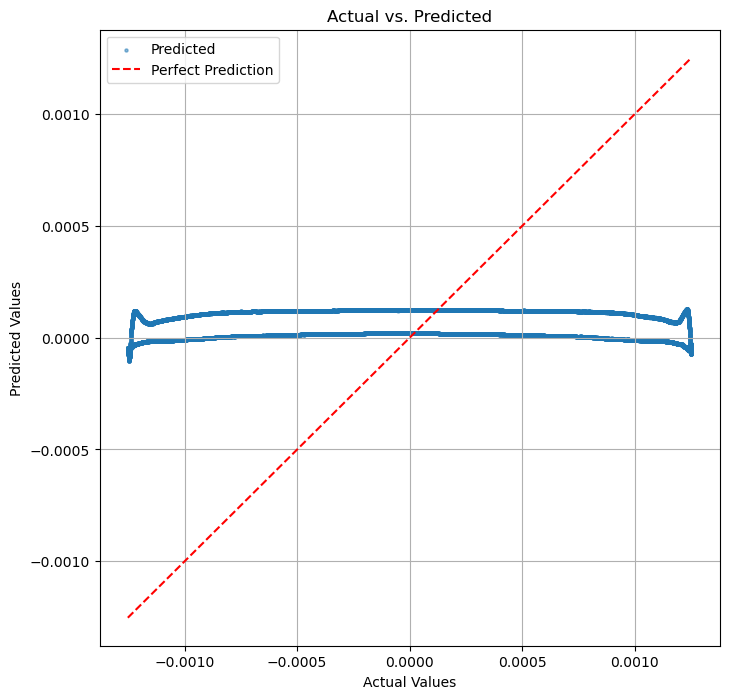

In [11]:
plot_model_predictions(mlp_model_sep, X_test, y_test)

In [124]:
def plot_sine_curve_and_model_predictions(model, steps: int = 250, period: float = 12.0):
    """
    Plots the actual sine curve and the model's version of the sine curve over a specified number of steps.
    The model is given 25 steps in the past at each timestep and predicts the change in value 30 minutes into the future.

    Parameters
    ----------
    model : Any
        A fitted model with a predict method that predicts the change in the sine value.
    steps : int
        The total number of steps (data points) to plot.
    period : float
        The period of the sine curve in arbitrary units.
    """
    # Generate the actual sine curve
    time_values = np.linspace(0, 2 * np.pi * steps / period, steps, endpoint=False)
    actual_sine_values = np.sin(time_values)
    
    # Initialize the predictions list with the first 25 actual values as the initial input
    model_input = actual_sine_values[:25]
    predicted_changes = np.empty(steps - 25)  # Adjusted to pre-allocate the array for efficiency

    for i in range(steps - 25):
        # Model predicts the change for the next step
        predicted_change = model.predict(model_input.reshape(1, -1))[1]
        # Ensure predicted_change is a single value by selecting the first element
        # This is important if your model.predict() returns an array instead of a single value
        predicted_change = predicted_change.flatten()[0]
        # The next value is the last value plus the predicted change
        next_value = model_input[-1] + predicted_change
        # Update the model input for the next prediction
        model_input = np.roll(model_input, -1)
        model_input[-1] = next_value
        # Store the predicted change
        predicted_changes[i] = next_value

    # The full model predictions including the initial values that were just copied
    model_predictions = np.concatenate([actual_sine_values[:25], predicted_changes])

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(time_values, actual_sine_values, label='Actual Sine Curve')
    plt.plot(time_values[25:], model_predictions[25:], label='Model Predictions', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Sine Value')
    plt.title('Actual Sine Curve vs Model Predictions')
    plt.legend()
    plt.show()

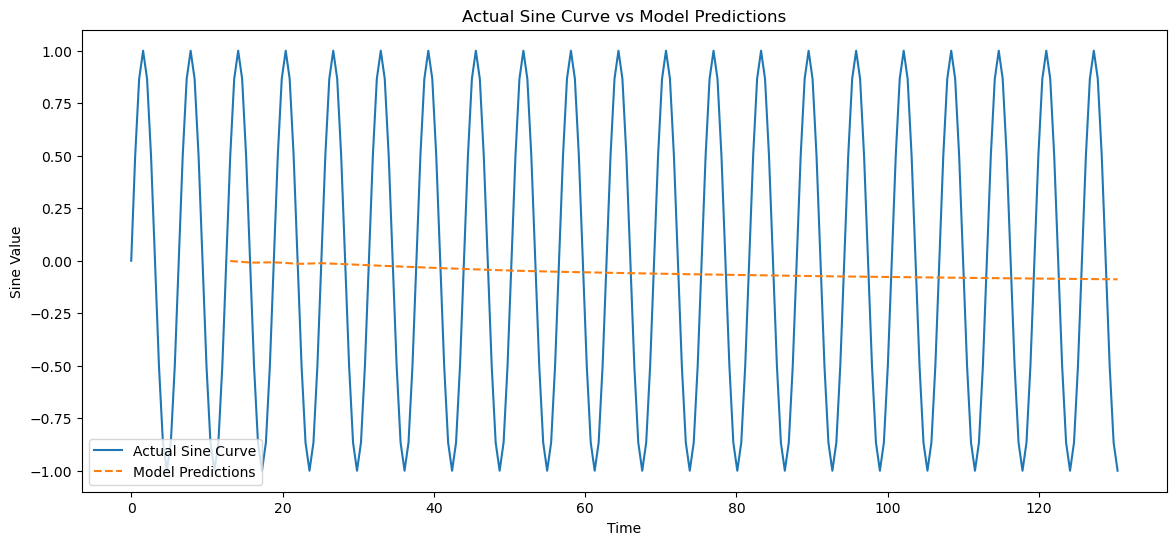

In [125]:
plot_sine_curve_and_model_predictions(mlp_model_sep)

In [76]:

def plot_line45_and_model_predictions(model, steps: int = 250):
    """
    Plots the actual normalized linear curve (as per synth_line45) and the model's predictions
    over a specified number of steps. The model is given 25 steps in the past at each timestep 
    and predicts the change in value 30 minutes into the future.

    Parameters
    ----------
    model : Any
        A fitted model with a predict method that predicts the change in value.
    steps : int
        The total number of steps (data points) to plot, including the initial 25 data points.
    """
    # Generate the actual linear curve, normalized over [0, 1] range
    time_values = np.linspace(0, 1, steps, endpoint=False)
    actual_values = time_values  # Directly use time_values as actual_values for a normalized 45-degree line
    
    # Initialize the predictions list with the first 25 actual values as the initial input
    model_input = actual_values[:25]
    predicted_values = np.empty(steps - 25)

    for i in range(steps - 25):
        # Model predicts the change for the next step
        predicted_change = model.predict(model_input.reshape(1, -1))[1]
        predicted_change = predicted_change.flatten() # Flatten the prediction to ensure it's a scalar
        # Calculate the next value based on the predicted change
        next_value = model_input[-1] + predicted_change
        # Update the model input for the next prediction
        model_input = np.roll(model_input, -1)
        model_input[-1] = next_value
        # Store the predicted value
        predicted_values[i] = next_value

    # The full model predictions including the initial values that were just copied
    model_predictions = np.concatenate([actual_values[:25], predicted_values])

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(time_values, actual_values, label='Actual Normalized Linear Curve')
    plt.plot(time_values[25:], model_predictions[25:], label='Model Predictions', linestyle='--')
    plt.xlabel('Normalized Time')
    plt.ylabel('Normalized Value')
    plt.title('Actual Normalized Linear Curve vs Model Predictions')
    plt.legend()
    plt.show()

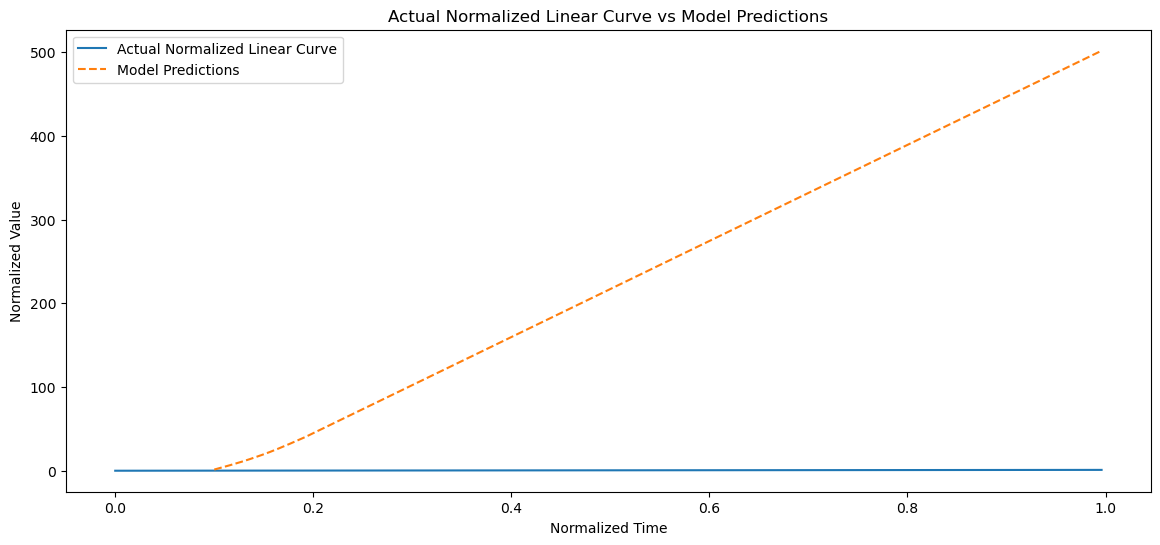

In [77]:
plot_line45_and_model_predictions(mlp_model_sep)